# Dental X-Ray Denoising with Autoencoder

*Aravind Kothandaraman*

*Unit 4 Incremental Capstone*

*Class 2509 TA*

**Objective:** Build an autoencoder to remove noise from dental X-ray images. The model will learn to reconstruct clean images from noisy versions.


## Imports


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


## Load and Preprocess Dataset


In [3]:
# Load the dataset
data = np.load('/content/drive/MyDrive/AI_ML_course/01-Incremental_Capstone/Unit4-DeepLearning/0.3_Datasets/DENTAL_1.NPZ')

data

NpzFile '/content/drive/MyDrive/AI_ML_course/01-Incremental_Capstone/Unit4-DeepLearning/0.3_Datasets/DENTAL_1.NPZ' with keys: x_train, y_train, x_test, y_test

In [4]:
# Extract arrays
X_train_clean = data['x_train']
X_test_clean = data['x_test']
y_train = data['y_train']
y_test = data['y_test']

print("Dataset shapes:")
print(f"Training images: {X_train_clean.shape}")
print(f"Test images: {X_test_clean.shape}")
print(f"Training labels: {y_train.shape}")
print(f"Test labels: {y_test.shape}")

# Check original pixel value range
print(f"\nOriginal pixel value range:")
print(f"Training: min={X_train_clean.min():.3f}, max={X_train_clean.max():.3f}")
print(f"Test: min={X_test_clean.min():.3f}, max={X_test_clean.max():.3f}")

Dataset shapes:
Training images: (92, 256, 256, 3)
Test images: (24, 256, 256, 3)
Training labels: (92,)
Test labels: (24,)

Original pixel value range:
Training: min=0.000, max=1.000
Test: min=0.000, max=1.000


In [5]:
print(X_train_clean.dtype)

float64


the datatypes of the `x_train_clean` and others are of `float64`. We will update those to `float32` below.

In [6]:
# Convert to float32 (data is already normalized to [0, 1] range)
# Do NOT divide by 255 - the data is already normalized!
# TODO: Convert X_train_clean and X_test_clean to float32
X_train_clean = X_train_clean.astype(np.float32)
X_test_clean = X_test_clean.astype(np.float32)

print(f"\nAfter conversion to float32:")
print(f"Training: min={X_train_clean.min():.3f}, max={X_train_clean.max():.3f}")
print(f"Test: min={X_test_clean.min():.3f}, max={X_test_clean.max():.3f}")
print(f"Training pixel data type: {X_train_clean.dtype}")
print(f"Test pixel data type: {X_test_clean.dtype}")


After conversion to float32:
Training: min=0.000, max=1.000
Test: min=0.000, max=1.000
Training pixel data type: float32
Test pixel data type: float32


## Add Gaussian Noise


In [7]:
# Add Gaussian noise to create noisy versions of the images
# This simulates real-world noise in X-ray images
# TODO: Set NOISE_FACTOR to 0.3 (controls the amount of noise)
NOISE_FACTOR = 0.3

def add_noise(images, noise_factor=NOISE_FACTOR):
    """
    Add Gaussian noise to images.

    Args:
        images: Clean images (normalized to [0, 1])
        noise_factor: Standard deviation of the noise (relative to image range)

    Returns:
        Noisy images
    """
    # Generate noise with same shape as images
    # TODO: Use np.random.normal() to generate noise
    # Parameters: loc=0.0, scale=noise_factor, size=images.shape
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=images.shape)

    # Add noise and clip to valid range [0, 1]
    # TODO: Add noise to images and clip to [0.0, 1.0] using np.clip()
    noisy_images = images + noise
    noisy_images = np.clip(noisy_images, 0, 1)

    return noisy_images



In [8]:
# test the function for experiementing
# add_noise(X_train_clean[:4])

array([[[[1.        , 0.82126582, 1.        ],
         [1.        , 0.80818537, 0.80819029],
         [1.        , 1.        , 0.76896161],
         ...,
         [1.        , 0.69005376, 0.89934805],
         [1.        , 0.81824086, 1.        ],
         [0.62041963, 0.82087601, 1.        ]],

        [[0.63936087, 1.        , 1.        ],
         [0.70576978, 1.        , 1.        ],
         [1.        , 0.43481494, 0.68774121],
         ...,
         [1.        , 0.69256087, 0.50333047],
         [0.92069725, 0.34789957, 0.97538169],
         [0.83807217, 0.742542  , 0.40394203]],

        [[0.98545259, 0.67156231, 0.48039751],
         [0.00498801, 0.8584122 , 1.        ],
         [1.        , 0.75306721, 0.70953247],
         ...,
         [0.99596993, 0.96473516, 1.        ],
         [1.        , 0.43535043, 1.        ],
         [0.6025426 , 0.78676941, 0.97702085]],

        ...,

        [[0.        , 0.16261617, 0.09975249],
         [0.45397054, 0.        , 0.        ]

Created noisy images with noise factor: 0.3
Training noisy images shape: (92, 256, 256, 3)
Test noisy images shape: (24, 256, 256, 3)


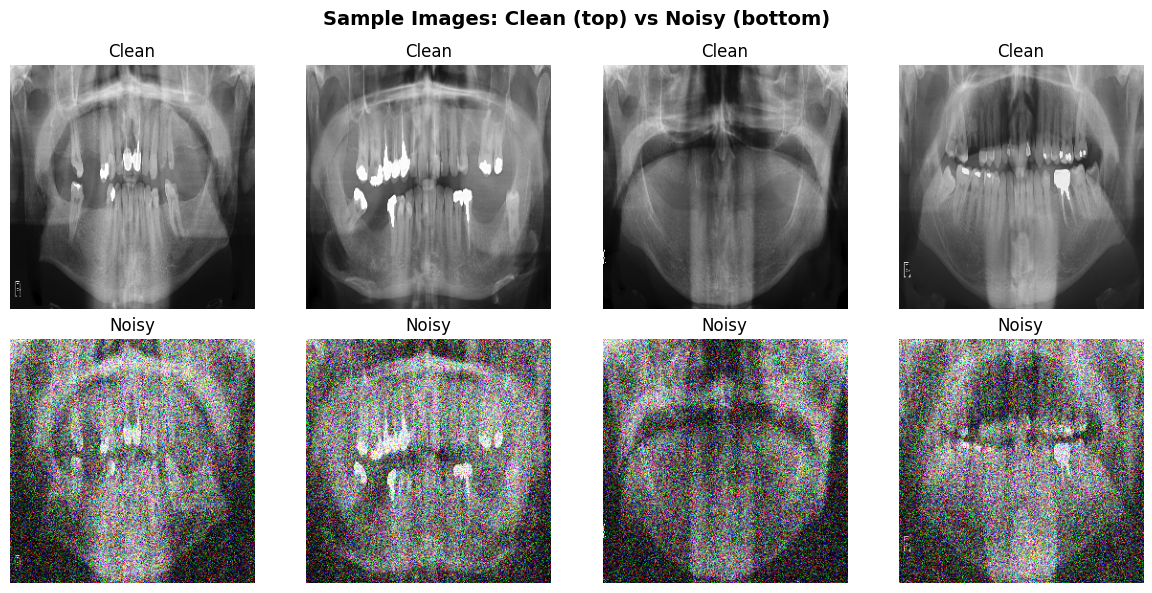

In [9]:
# Create noisy versions of training and test images
X_train_noisy = add_noise(X_train_clean, noise_factor=NOISE_FACTOR)
X_test_noisy = add_noise(X_test_clean, noise_factor=NOISE_FACTOR)

print(f"Created noisy images with noise factor: {NOISE_FACTOR}")
print(f"Training noisy images shape: {X_train_noisy.shape}")
print(f"Test noisy images shape: {X_test_noisy.shape}")

# Display sample images to see the noise
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
    # Clean images (top row)
    axes[0, i].imshow(X_train_clean[i])
    axes[0, i].set_title('Clean')
    axes[0, i].axis('off')

    # Noisy images (bottom row)
    axes[1, i].imshow(X_train_noisy[i])
    axes[1, i].set_title('Noisy')
    axes[1, i].axis('off')

plt.suptitle('Sample Images: Clean (top) vs Noisy (bottom)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Build Autoencoder Model


In [10]:
# Build autoencoder for image denoising
# Input shape: (256, 256, 3) - RGB images

# Encoder: Compresses the image to a lower-dimensional representation
encoder = models.Sequential([
  layers.Input(shape=(256, 256, 3)),
  layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", padding = "same"),
  layers.MaxPooling2D(pool_size = (2, 2), padding = "same"),  # 128x128
  layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", padding = "same"),
  layers.MaxPooling2D(pool_size = (2, 2), padding = "same"),  # 64x64
  layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = "relu", padding = "same"),
  layers.MaxPooling2D(pool_size = (2, 2), padding = "same"),  # 32x32
])

# Decoder: Reconstructs the image from the compressed representation
decoder = models.Sequential([
    layers.Conv2DTranspose(filters = 128, kernel_size = (3, 3), strides = 2, activation = "relu", padding = "same"),  # 64x64
    layers.Conv2DTranspose(filters = 64, kernel_size = (3, 3), strides = 2, activation = "relu", padding = "same"),   # 128x128
    layers.Conv2DTranspose(filters = 32, kernel_size = (3, 3), strides = 2, activation = "relu", padding = "same"),  # 256x256
    layers.Conv2D(filters = 3, kernel_size = (3, 3), activation = "sigmoid", padding = "same"),  # Output: 256x256x3
])

# Combine encoder and decoder
autoencoder = models.Sequential([encoder, decoder])

# Compile the model
autoencoder.compile(
    optimizer = "adam",
    loss = "mse",  # Mean Squared Error for reconstruction
    metrics=["mae"]  # Mean Absolute Error
)

autoencoder.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 32, 32, 128)    │        93,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │       240,707 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Autoencoder


In [11]:
# Set up callbacks
callbacks = [
    EarlyStopping(
        monitor = "val_loss",
        patience = 10,
        restore_best_weights = True,
        verbose = 1
    ),
    # TODO: Create ReduceLROnPlateau callback with:
    ReduceLROnPlateau(
        monitor = "val_loss",
        factor = 0.5,
        patience = 5,
        min_lr = 1e-7,
        verbose = 1
    )
]

# Train the autoencoder
# Input: noisy images, Target: clean images
# The model learns to reconstruct clean images from noisy ones
history = autoencoder.fit(
    X_train_noisy,  # Input: noisy images
    X_train_clean,  # Target: clean images
    validation_data = (X_test_noisy, X_test_clean),
    epochs = 50,
    batch_size = 8,
    callbacks = callbacks,
    verbose = 1
)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 940ms/step - loss: 0.0493 - mae: 0.1781 - val_loss: 0.0390 - val_mae: 0.1622 - learning_rate: 0.0010
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0280 - mae: 0.1306 - val_loss: 0.0159 - val_mae: 0.0938 - learning_rate: 0.0010
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0142 - mae: 0.0852 - val_loss: 0.0127 - val_mae: 0.0767 - learning_rate: 0.0010
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0122 - mae: 0.0751 - val_loss: 0.0122 - val_mae: 0.0746 - learning_rate: 0.0010
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0117 - mae: 0.0726 - val_loss: 0.0118 - val_mae: 0.0732 - learning_rate: 0.0010
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0114 - mae: 0.0708 - val_loss: 0.0115 - val_mae: 0.0719 - learning_rate: 0.0010
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0110 - mae: 0.0693 - val_loss: 0.0111 - val_mae: 0.0694 - learning_rate: 0.0010
Epoch 8/50


## Evaluate and Visualize Results


In [12]:
# Evaluate on test set
test_loss, test_mae = autoencoder.evaluate(X_test_noisy , X_test_clean, verbose = 0)
print(f"Test Loss (MSE): {test_loss:.6f}")
print(f"Test MAE: {test_mae:.6f}")

# Generate predictions (denoised images)
denoised_images = autoencoder.predict(X_test_noisy, verbose = 0)

print(f"\nDenoised images shape: {denoised_images.shape}")
print(f"Denoised pixel range: [{denoised_images.min():.3f}, {denoised_images.max():.3f}]")


Test Loss (MSE): 0.002584
Test MAE: 0.034762

Denoised images shape: (24, 256, 256, 3)
Denoised pixel range: [0.006, 0.989]


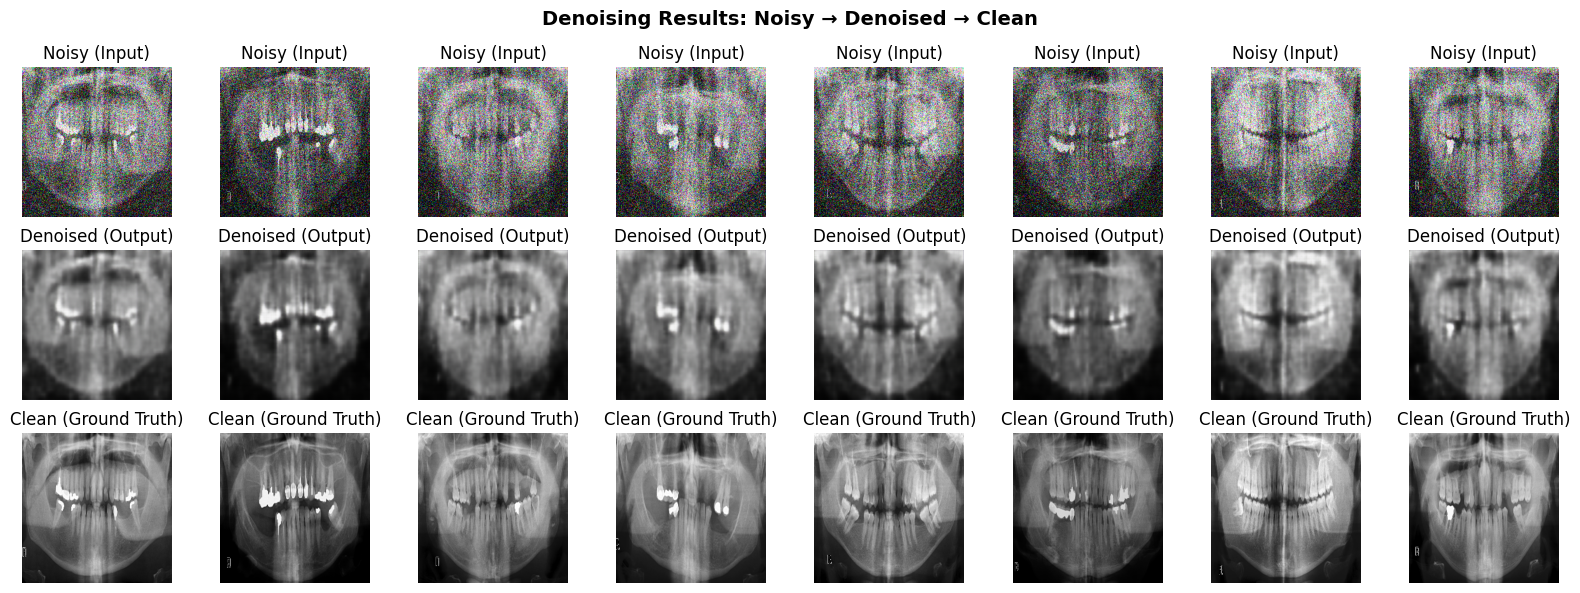

In [13]:
# Visualize results: Compare noisy, denoised, and clean images
n_samples = 8
fig, axes = plt.subplots(3, n_samples, figsize=(16, 6))

for i in range(n_samples):
    # Row 1: Noisy images (input)
    axes[0, i].imshow(X_test_noisy[i])
    axes[0, i].set_title('Noisy (Input)')
    axes[0, i].axis('off')

    # Row 2: Denoised images (model output)
    axes[1, i].imshow(denoised_images[i])
    axes[1, i].set_title('Denoised (Output)')
    axes[1, i].axis('off')

    # Row 3: Clean images (ground truth)
    axes[2, i].imshow(X_test_clean[i])
    axes[2, i].set_title('Clean (Ground Truth)')
    axes[2, i].axis('off')

plt.suptitle('Denoising Results: Noisy → Denoised → Clean', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


Reconstruction Error Statistics:
Mean MSE per image: 0.002584
Mean MAE per image: 0.034762

Best reconstruction (lowest MSE): Image 13
Worst reconstruction (highest MSE): Image 1


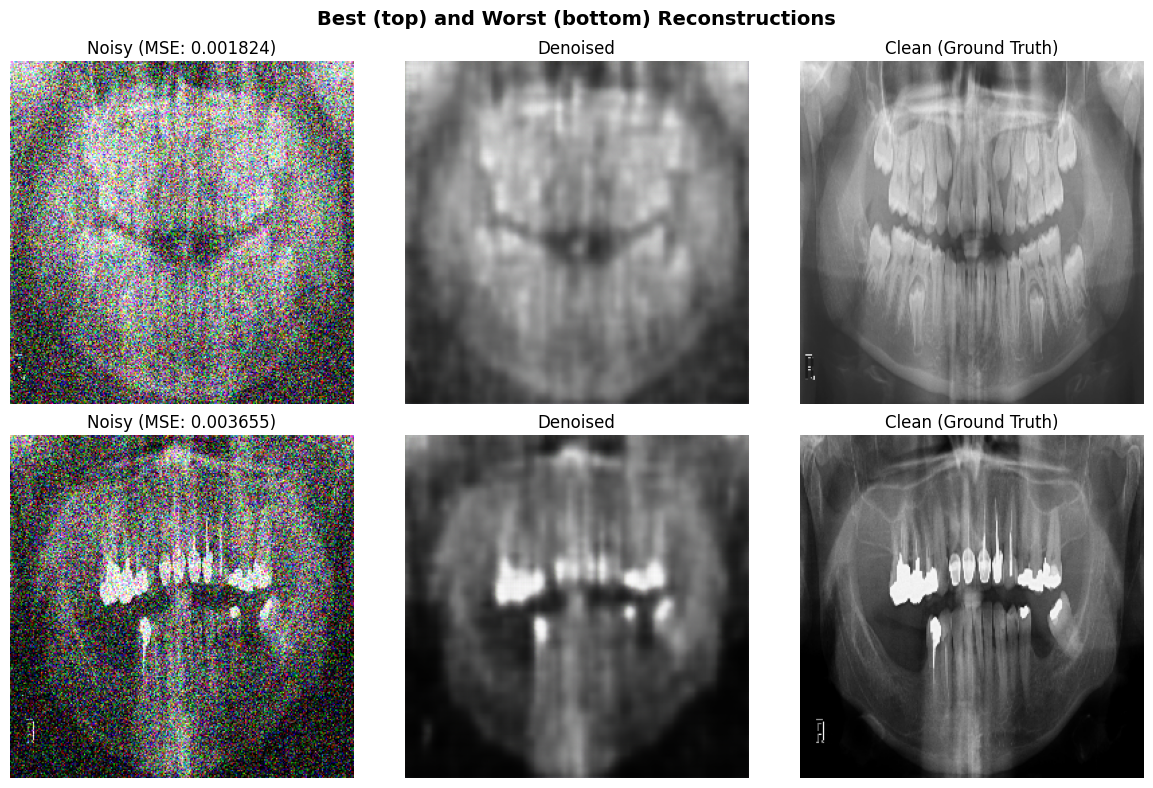

In [14]:
# Calculate reconstruction error for each test image
mse_per_image = np.mean((X_test_clean - denoised_images) ** 2, axis=(1, 2, 3))

# Use axis=(1, 2, 3) to average across height, width, and channels
mae_per_image = np.mean(np.abs(X_test_clean - denoised_images), axis=(1, 2, 3))

print("Reconstruction Error Statistics:")
print(f"Mean MSE per image: {np.mean(mse_per_image):.6f}")
print(f"Mean MAE per image: {np.mean(mae_per_image):.6f}")
print(f"\nBest reconstruction (lowest MSE): Image {np.argmin(mse_per_image)}")
print(f"Worst reconstruction (highest MSE): Image {np.argmax(mse_per_image)}")

# Visualize best and worst reconstructions
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Best reconstruction
best_idx = np.argmin(mse_per_image)
axes[0, 0].imshow(X_test_noisy[best_idx])
axes[0, 0].set_title(f'Noisy (MSE: {mse_per_image[best_idx]:.6f})')
axes[0, 0].axis('off')

axes[0, 1].imshow(denoised_images[best_idx])
axes[0, 1].set_title('Denoised')
axes[0, 1].axis('off')

axes[0, 2].imshow(X_test_clean[best_idx])
axes[0, 2].set_title('Clean (Ground Truth)')
axes[0, 2].axis('off')

# Worst reconstruction
worst_idx = np.argmax(mse_per_image)
axes[1, 0].imshow(X_test_noisy[worst_idx])
axes[1, 0].set_title(f'Noisy (MSE: {mse_per_image[worst_idx]:.6f})')
axes[1, 0].axis('off')

axes[1, 1].imshow(denoised_images[worst_idx])
axes[1, 1].set_title('Denoised')
axes[1, 1].axis('off')

axes[1, 2].imshow(X_test_clean[worst_idx])
axes[1, 2].set_title('Clean (Ground Truth)')
axes[1, 2].axis('off')

plt.suptitle('Best (top) and Worst (bottom) Reconstructions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Plot Training History


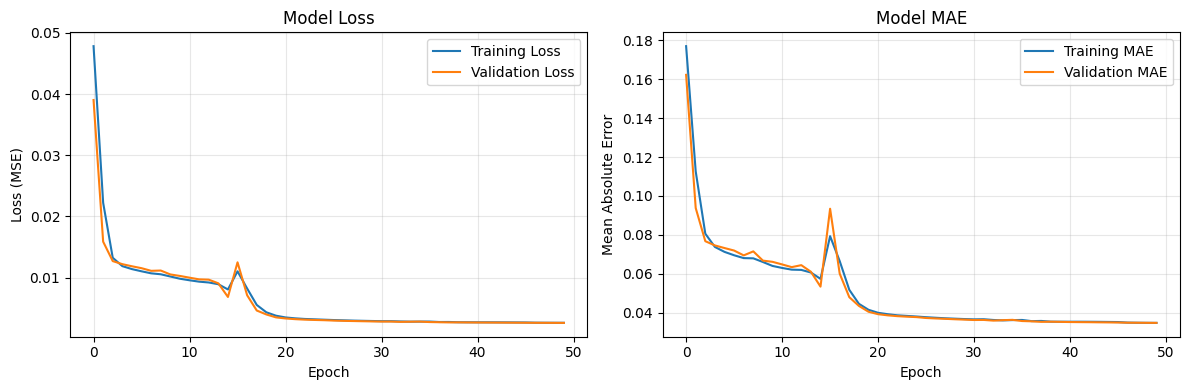

In [15]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
# TODO: Plot history.history['loss'] and history.history['val_loss']
axes[0].plot(history.history["loss"], label='Training Loss')
axes[0].plot(history.history["val_loss"], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Model Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# MAE plot
# TODO: Plot history.history['mae'] and history.history['val_mae']
axes[1].plot(history.history["mae"], label='Training MAE')
axes[1].plot(history.history["val_mae"], label='Validation MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].set_title('Model MAE')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

The workflow for denoising dental X-ray images using an autoencoder can be summarized as follows:

## Data Loading and Preprocessing:

- The dental X-ray dataset (DENTAL_1.NPZ) is loaded, providing clean training and test images (X_train_clean, X_test_clean) and their corresponding labels.
- The pixel data types are converted to float32 for compatibility with TensorFlow models, ensuring that the images are already normalized to a [0, 1] range.

## Adding Gaussian Noise:

- A custom function `add_noise()` is used to introduce Gaussian noise to the clean images.
- This step simulates real-world noise in X-ray images, creating `X_train_noisy` and `X_test_noisy` datasets. The `NOISE_FACTOR` controls the intensity of the noise.
- Sample images are visualized to demonstrate the effect of the added noise.

## Building the Autoencoder Model:

- An autoencoder model is constructed using __TensorFlow/Keras__, consisting of an encoder and a decoder.
- **Encoder**: This part compresses the input (noisy image) using Conv2D and MaxPooling2D layers, extracting features and reducing spatial dimensions until a bottleneck representation (e.g., 32x32x128) is reached.
- **Decoder**: This part takes the compressed representation and reconstructs a clean image using `Conv2DTranspose` (upsampling) layers, followed by a final Conv2D layer with a sigmoid activation to output pixel values in the [0, 1] range.
- The model is compiled with the Adam optimizer and Mean Squared Error (mse) as the loss function (appropriate for reconstruction tasks), and Mean Absolute Error (mae) as a metric.

## Training the Autoencoder:

- The model is trained using the noisy images (X_train_noisy) as input and the corresponding clean images (X_train_clean) as targets. This teaches the autoencoder to map noisy inputs to clean outputs.
- Callbacks like `EarlyStopping` (to prevent overfitting) and `ReduceLROnPlateau` (to adjust the learning rate) are used to optimize the training process.

## Evaluation and Visualization:

- The trained autoencoder is evaluated on the test set (`X_test_noisy`, `X_test_clean`) to calculate the overall test loss and MAE.
- The model generates denoised images from the `X_test_noisy` set.
- A visualization step compares the noisy input, the denoised output, and the clean ground truth images for several samples, allowing for a qualitative assessment of the denoising performance.
- Reconstruction errors (MSE and MAE) are calculated per image, and the best and worst reconstructions are highlighted to analyze the model's strengths and weaknesses.

## Plotting Training History:

Plots of training and validation loss, as well as training and validation MAE, are generated to visualize the model's learning progression and identify potential overfitting or underfitting.

(*Used AI to help produce this, but helps me as well for learning*)

The autoencoder architecture defined consists of two main parts:

### Encoder

```python
encoder = models.Sequential([
  layers.Input(shape=(256, 256, 3)),
  layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", padding = "same"),
  layers.MaxPooling2D(pool_size = (2, 2), padding = "same"),  # 128x128
  layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", padding = "same"),
  layers.MaxPooling2D(pool_size = (2, 2), padding = "same"),  # 64x64
  layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = "relu", padding = "same"),
  layers.MaxPooling2D(pool_size = (2, 2), padding = "same"),  # 32x32
])
```

**Explanation:**
*   `layers.Input(shape=(256, 256, 3))`: This defines the expected input shape for the images: 256 pixels high, 256 pixels wide, and 3 channels (for RGB). For dental X-rays, which are often grayscale, this typically means the image data is replicated across all three channels.
*   `layers.Conv2D`: These are convolutional layers that extract features from the image. They apply filters to detect patterns like edges, textures, etc.
    *   `filters`: The number of filters (e.g., 32, 64, 128) determines the depth of the output feature map. More filters allow the network to learn more diverse features.
    *   `kernel_size=(3, 3)`: The size of the sliding window (filter) used to convolve over the input. A 3x3 kernel is common for capturing local patterns.
    *   `activation="relu"`: The Rectified Linear Unit activation function introduces non-linearity, allowing the model to learn complex relationships.
    *   `padding="same"`: This ensures the output feature map has the same spatial dimensions (height and width) as the input *before* pooling, by adding zero-padding around the input if necessary.
*   `layers.MaxPooling2D`: These layers reduce the spatial dimensions (height and width) of the feature maps, effectively downsampling the image.
    *   `pool_size=(2, 2)`: Reduces the dimension by half, e.g., from 256x256 to 128x128. This helps in making the model more robust to small shifts and distortions, and it also reduces computational complexity.

**How dimensions change in the encoder:**

Input: (256, 256, 3)
1.  `Conv2D(32)` -> (256, 256, 32)
2.  `MaxPooling2D` -> (128, 128, 32)
3.  `Conv2D(64)` -> (128, 128, 64)
4.  `MaxPooling2D` -> (64, 64, 64)
5.  `Conv2D(128)` -> (64, 64, 128)
6.  `MaxPooling2D` -> (32, 32, 128) - This is the bottleneck/latent space representation.

### Decoder

```python
decoder = models.Sequential([
    layers.Conv2DTranspose(filters = 128, kernel_size = (3, 3), strides = 2, activation = "relu", padding = "same"),  # 64x64
    layers.Conv2DTranspose(filters = 64, kernel_size = (3, 3), strides = 2, activation = "relu", padding = "same"),   # 128x128
    layers.Conv2DTranspose(filters = 32, kernel_size = (3, 3), strides = 2, activation = "relu", padding = "same"),  # 256x256
    layers.Conv2D(filters = 3, kernel_size = (3, 3), activation = "sigmoid", padding = "same"),  # Output: 256x256x3
])
```

**Explanation:**
*   `layers.Conv2DTranspose`: These are also known as "deconvolutional" layers. They perform the inverse operation of convolution and are used to upsample the feature maps, increasing their spatial dimensions.
    *   `strides = 2`: This is crucial for upsampling. It effectively doubles the spatial dimensions (height and width) of the input, e.g., from 32x32 to 64x64.
    *   `filters`, `kernel_size`, `activation`, `padding`: Similar to `Conv2D`, these parameters control the feature extraction and processing during upsampling.
*   `layers.Conv2D(filters = 3, kernel_size = (3, 3), activation = "sigmoid", padding = "same")`: The final layer is a standard `Conv2D` layer.
    *   `filters = 3`: To produce an RGB image, the output must have 3 channels.
    *   `activation="sigmoid"`: The sigmoid activation function constrains the output pixel values to the range [0, 1], which is suitable for normalized image data.

**How dimensions change in the decoder:**

Input: (32, 32, 128) (from the encoder bottleneck)
1.  `Conv2DTranspose(128, strides=2)` -> (64, 64, 128)
2.  `Conv2DTranspose(64, strides=2)` -> (128, 128, 64)
3.  `Conv2DTranspose(32, strides=2)` -> (256, 256, 32)
4.  `Conv2D(3)` -> (256, 256, 3) - This is the reconstructed denoised image.

# Role of the bottleneck layer

- The bottleneck layer is the most compressed representation of the input image within the autoencoder.
- it's the output of the final `MaxPooling2D` layer in the encoder, reducing the image from (256x256x3) down to (32x32x128).
- Its primary role is to force the autoencoder to learn the most salient and essential features of the input data. By constraining the information flow through this narrow bottleneck, the model is compelled to prioritize and preserve only the most important patterns necessary for reconstructing the image. This effectively removes redundancy and noise.

### Critical Thinking

14. **Limitations:** What are the limitations of this autoencoder approach? When might it fail? Are there scenarios where denoising might remove important details from medical images?
> Autoencoders, especially those using `Mean Squared Error (MSE)` as a loss function, tend to produce images that are perceptually 'blurry' or 'over-smoothed'. MSE heavily penalizes large pixel-wise differences, which can lead the model to favor averaged solutions.


15. **Ethical considerations:** In medical imaging, image quality can affect diagnosis. What are the ethical implications of using AI to denoise medical images? Should denoised images be clearly labeled as processed?
> In my opinion, it should be labeled. So, any assumptions based on the denoised images can be considered to revisit while there's an human in the loop who may assume otherwise.

---

## Questions to Consider

Reflect on what you've learned and explore further:

### Understanding the Model

1. **How does an autoencoder work?** Explain the difference between the encoder and decoder components. What happens to the image dimensions as it passes through the encoder? How does the decoder reconstruct the image?

2. **Why use MSE (Mean Squared Error) as the loss function?** What does MSE measure, and why is it appropriate for image reconstruction tasks? How would the results differ if you used a different loss function?

3. **What role does the bottleneck play?** The encoder compresses the image from 256×256×3 down to 32×32×128. What information is preserved in this compressed representation? What information might be lost?

### Model Performance

4. **Analyze the reconstruction quality:** Compare the best and worst reconstructions. What characteristics make some images easier to denoise than others? Are there patterns in the images that the model struggles with?

5. **Noise factor impact:** How would changing the `NOISE_FACTOR` affect the model's performance? Try different values (e.g., 0.1, 0.5, 0.7) and observe how the denoising quality changes. What happens when the noise is too strong?

6. **Training observations:** Look at the training history plots. Did the model converge? Were there signs of overfitting or underfitting? How did the validation loss compare to training loss?

### Experimentation Ideas

7. **Architecture modifications:** Try modifying the autoencoder architecture:
   - Add more layers to the encoder/decoder
   - Change the number of filters in each layer
   - Add dropout layers to prevent overfitting
   - Experiment with different activation functions

8. **Different noise types:** Instead of Gaussian noise, try:
   - Salt-and-pepper noise
   - Poisson noise (common in medical imaging)
   - Motion blur
   - How does the model perform with different noise types?

9. **Loss function alternatives:** Experiment with different loss functions:
   - Perceptual loss (using a pre-trained network)
   - SSIM (Structural Similarity Index)
   - Combination of MSE and MAE
   - How do these affect reconstruction quality?

10. **Real-world applications:** Where else could autoencoders be useful?
    - Image compression
    - Anomaly detection
    - Feature extraction
    - Data augmentation
    - What other medical imaging tasks could benefit from denoising?

### Further Exploration

11. **Compare with other methods:** Research traditional image denoising techniques (e.g., Gaussian blur, median filtering, bilateral filtering). How do they compare to the autoencoder approach? What are the advantages and disadvantages of each?

12. **Variational Autoencoders (VAEs):** Research VAEs and how they differ from standard autoencoders. What additional capabilities do they provide? When would you choose a VAE over a standard autoencoder?

13. **Transfer learning:** Could you use a pre-trained encoder (e.g., from ImageNet) and only train the decoder? How would this affect training time and performance?

### Critical Thinking

14. **Limitations:** What are the limitations of this autoencoder approach? When might it fail? Are there scenarios where denoising might remove important details from medical images?

15. **Ethical considerations:** In medical imaging, image quality can affect diagnosis. What are the ethical implications of using AI to denoise medical images? Should denoised images be clearly labeled as processed?
